# Lesson 29 - Classification Metrics

## Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

spark = SparkSession.builder.getOrCreate()

## Introduction 
In this lesson, we will demonstrate how to use the `MulticlassMetrics` class from `pyspark.mllib.evaluation` to create a confusion matrix and to calculate classification metrics such as accuracy, precision, and recall.

## Load and Prepare Data

In this lesson, we will be working with the diamonds dataset. This dataset contains information for about 54,000 diamonds sold in the US. For each diamond, we are provided with the following information: The `price`, the `carat` size, the `x`, `y`, and `z` measurements, the `depth` and `table` measurements, and the values for three qualitative (categorical) characteristics known as `cut`, `color`, and `clarity`. You can find more information about this dataset here: [Diamonds dataset](https://ggplot2.tidyverse.org/reference/diamonds.html)

In this example, we will create a model to attempt to predict a diamond's cut classification using all other columns as features.

In [0]:
diamonds = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .schema(
        'carat DOUBLE, cut STRING, color STRING, clarity STRING, depth DOUBLE, '
        'table DOUBLE, price INTEGER, x DOUBLE, y DOUBLE, z DOUBLE'
    )
    .csv('/FileStore/tables/diamonds.txt')
)

diamonds.printSchema()

root
-- carat: double (nullable = true)
-- cut: string (nullable = true)
-- color: string (nullable = true)
-- clarity: string (nullable = true)
-- depth: double (nullable = true)
-- table: double (nullable = true)
-- price: integer (nullable = true)
-- x: double (nullable = true)
-- y: double (nullable = true)
-- z: double (nullable = true)

In [0]:
diamonds.show(10)

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
carat| cut|color|clarity|depth|table|price| x| y| z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
 0.23| Ideal| E| SI2| 61.5| 55.0| 326|3.95|3.98|2.43|
 0.21| Premium| E| SI1| 59.8| 61.0| 326|3.89|3.84|2.31|
 0.23| Good| E| VS1| 56.9| 65.0| 327|4.05|4.07|2.31|
 0.29| Premium| I| VS2| 62.4| 58.0| 334| 4.2|4.23|2.63|
 0.31| Good| J| SI2| 63.3| 58.0| 335|4.34|4.35|2.75|
 0.24|Very Good| J| VVS2| 62.8| 57.0| 336|3.94|3.96|2.48|
 0.24|Very Good| I| VVS1| 62.3| 57.0| 336|3.95|3.98|2.47|
 0.26|Very Good| H| SI1| 61.9| 55.0| 337|4.07|4.11|2.53|
 0.22| Fair| E| VS2| 65.1| 61.0| 337|3.87|3.78|2.49|
 0.23|Very Good| H| VS1| 59.4| 61.0| 338| 4.0|4.05|2.39|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
only showing top 10 rows

In [0]:
N = diamonds.count()
print(N)

53940

### Log Transformations

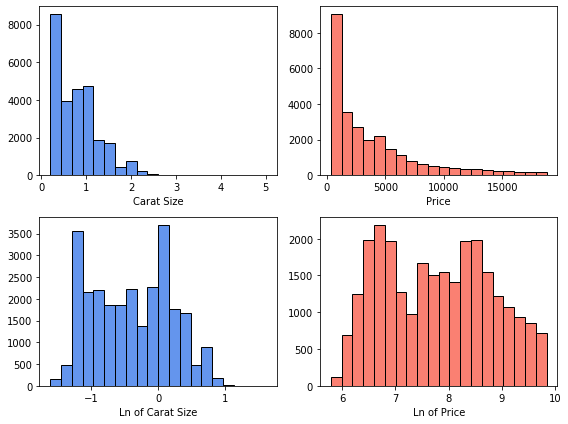

In [0]:
sample_pdf = diamonds.sample(withReplacement=False, fraction=0.5, seed=1).toPandas()

plt.figure(figsize=[8,6])
plt.subplot(2,2,1)
plt.hist(sample_pdf.carat, bins=20, color='cornflowerblue', edgecolor='k')
plt.xlabel('Carat Size')
plt.subplot(2,2,2)
plt.hist(sample_pdf.price, bins=20, color='salmon', edgecolor='k')
plt.xlabel('Price')
plt.subplot(2,2,3)
plt.hist(np.log(sample_pdf.carat), bins=20, color='cornflowerblue', edgecolor='k')
plt.xlabel('Ln of Carat Size')
plt.subplot(2,2,4)
plt.hist(np.log(sample_pdf.price), bins=20, color='salmon', edgecolor='k')
plt.xlabel('Ln of Price')

plt.tight_layout()
plt.show()


In [0]:
diamonds = diamonds.select('*', expr('LOG(carat) AS ln_carat'), expr('LOG(price) AS ln_price'))
diamonds.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+-------------------+------------------+
carat| cut|color|clarity|depth|table|price| x| y| z| ln_carat| ln_price|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-------------------+------------------+
 0.23| Ideal| E| SI2| 61.5| 55.0| 326|3.95|3.98|2.43|-1.4696759700589417| 5.786897381366708|
 0.21| Premium| E| SI1| 59.8| 61.0| 326|3.89|3.84|2.31|-1.5606477482646683| 5.786897381366708|
 0.23| Good| E| VS1| 56.9| 65.0| 327|4.05|4.07|2.31|-1.4696759700589417|5.7899601708972535|
 0.29| Premium| I| VS2| 62.4| 58.0| 334| 4.2|4.23|2.63|-1.2378743560016174| 5.8111409929767|
 0.31| Good| J| SI2| 63.3| 58.0| 335|4.34|4.35|2.75| -1.171182981502945| 5.814130531825066|
 0.24|Very Good| J| VVS2| 62.8| 57.0| 336|3.94|3.96|2.48|-1.4271163556401458| 5.817111159963204|
 0.24|Very Good| I| VVS1| 62.3| 57.0| 336|3.95|3.98|2.47|-1.4271163556401458| 5.817111159963204|
 0.26|Very Good| H| SI1| 61.9| 55.0| 337|4.07|4.11|2.53|-1.3470736479666092| 5.820082930352362|
 0.22| Fair| E| VS2| 65.1| 61.0| 337|3.87|3.78|2.49|-1.5141277326297755| 5.820082930352362|
 0.23|Very Good| H| VS1| 59.4| 61.0| 338| 4.0|4.05|2.39|-1.4696759700589417| 5.823045895483019|
 0.3| Good| J| SI1| 64.0| 55.0| 339|4.25|4.28|2.73|-1.2039728043259361| 5.82600010738045|
 0.23| Ideal| J| VS1| 62.8| 56.0| 340|3.93| 3.9|2.46|-1.4696759700589417|5.8289456176102075|
 0.22| Premium| F| SI1| 60.4| 61.0| 342|3.88|3.84|2.33|-1.5141277326297755| 5.834810737062605|
 0.31| Ideal| J| SI2| 62.2| 54.0| 344|4.35|4.37|2.71| -1.171182981502945| 5.840641657373398|
 0.2| Premium| E| SI2| 60.2| 62.0| 345|3.79|3.75|2.27|-1.6094379124341003| 5.84354441703136|
 0.32| Premium| E| I1| 60.9| 58.0| 345|4.38|4.42|2.68|-1.1394342831883648| 5.84354441703136|
 0.3| Ideal| I| SI2| 62.0| 54.0| 348|4.31|4.34|2.68|-1.2039728043259361|5.8522024797744745|
 0.3| Good| J| SI1| 63.4| 54.0| 351|4.23|4.29| 2.7|-1.2039728043259361| 5.860786223465865|
 0.3| Good| J| SI1| 63.8| 56.0| 351|4.23|4.26|2.71|-1.2039728043259361| 5.860786223465865|
 0.3|Very Good| J| SI1| 62.7| 59.0| 351|4.21|4.27|2.66|-1.2039728043259361| 5.860786223465865|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-------------------+------------------+
only showing top 20 rows

### Distribution of Label Values

To serve as a baseline against which we can compare our model, we will check the distribution of the label values.

In [0]:
(
    diamonds
    .select('cut')
    .groupby('cut')
    .agg(
        expr('COUNT(*) as count'), 
        expr(f'ROUND(COUNT(*)/{N},4) as prop')
    )
    .show()
)

+---------+-----+------+
 cut|count| prop|
+---------+-----+------+
 Premium|13791|0.2557|
 Ideal|21551|0.3995|
 Good| 4906| 0.091|
 Fair| 1610|0.0298|
Very Good|12082| 0.224|
+---------+-----+------+

### Numerical and Categorical Features

We need to create lists specifying the names of our numerical features and our categorical features.

In [0]:
num_features = ['ln_carat', 'ln_price', 'x', 'y', 'z', 'depth', 'table']
cat_features = ['color', 'clarity']

### Pipelines

In [0]:
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

label_indexer = StringIndexer(inputCol='cut', outputCol='label')

feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

assembler = VectorAssembler(inputCols=num_features + vec_features, outputCol='features')

logreg = LogisticRegression(featuresCol='features', labelCol='label')

### Train Model and Generate Predictions

In [0]:
model = Pipeline(stages=[label_indexer, feature_indexer, encoder, assembler, logreg]).fit(diamonds)
train_pred = model.transform(diamonds)

train_pred.select(['probability', 'prediction', 'label']).show(10, truncate=False)

+------------------------------------------------------------------------------------------------------+----------+-----+
probability |prediction|label|
+------------------------------------------------------------------------------------------------------+----------+-----+
[0.6173323884726053,0.11379282057363908,0.1295460752564795,0.056878843181463835,0.08244987251581218] |0.0 |0.0 |
[0.07103609339483809,0.4695917580823786,0.2124291401173746,0.2403077710682959,0.006635237337112977] |1.0 |1.0 |
[0.005631296260543399,0.6607103978594551,0.11684283699774121,0.21641934413960454,3.961247426559095E-4]|1.0 |3.0 |
[0.3061430413527848,0.24874478651756235,0.26962423821130205,0.14907266084703197,0.026415273071318714] |0.0 |1.0 |
[0.19971849573994102,0.1697183455743611,0.1641285187582834,0.20321823990592536,0.2632164000214891] |4.0 |3.0 |
[0.5944086925153124,0.1259682929509874,0.2211203823244292,0.036398015818099164,0.022104616391172015] |0.0 |2.0 |
[0.6114580288226584,0.1312485548731358,0.22825394395707815,0.0241567659739326,0.00488270637319505] |0.0 |2.0 |
[0.6161815360615336,0.10736111407579564,0.16072629700784097,0.05551254881461233,0.06021850404021745] |0.0 |2.0 |
[0.15316322410100322,0.30267187436183335,0.3685189534512601,0.1537738836277729,0.021872064458130384] |2.0 |4.0 |
[0.10820319173597905,0.5237659657338529,0.20819574932007895,0.15358147447697348,0.006253618733115384] |1.0 |2.0 |
+------------------------------------------------------------------------------------------------------+----------+-----+
only showing top 10 rows

In [0]:
model.stages[0].labels # to look at the label encoder in more details

Out[16]: ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

### Create Prediction/Label Pair RDD

The `MulticlassMetrics` class is from the RDD based `pyspark.mllib` module. To use this tool, we need to create a pair RDD that contains prediction and label values for each observation.

In [0]:
# let's manually calculate accuracy

train_pred.filter(expr('prediction == label')).count() / N

Out[18]: 0.5665925101965147

In [0]:
for x in train_pred.rdd.take(5):
    print(x['cut'], x['price'])

Ideal 326
Premium 326
Good 327
Premium 334
Good 335

In [0]:
pred_and_labels = train_pred.rdd.map(lambda x : (x['prediction'], x['label']) )
pred_and_labels.persist()

for item in pred_and_labels.take(5):
    print(item)
    

(0.0, 0.0)
(1.0, 1.0)
(1.0, 3.0)
(0.0, 1.0)
(4.0, 3.0)

## Accuracy

We will now determine the model's accuracy on the training set.

In [0]:
metrics = MulticlassMetrics(pred_and_labels)
print(metrics.accuracy)

0.5665925101965147

## Confusion Matrix

Next we will use our `metrics` object to generate a confusion matrix.

In [0]:
labels = model.stages[0].labels

In [0]:
#          pred_0, pred_1, pred_2
# actual_0   num ,  num  ,  num
# actual_1   num ,  num  ,  num
# actual_2   num ,  num  ,  num
cm = metrics.confusionMatrix().toArray().astype(int)

pd.DataFrame(
    data=cm, 
    columns=labels,
    index=labels
)


Out[14]:

,Ideal,Premium,Very Good,Good,Fair
Ideal,19883,1104,562,1,1
Premium,3731,8680,1369,9,2
Very Good,5905,4420,1725,18,14
Good,1914,1848,1097,17,30
Fair,408,408,508,29,257


## Precision and Recall by Class

We will conclude by calculate the model's precision and recall for each level of the `cut` variable. 

- TP Pred positive, actually positive
- FP Pred positive, actually negative
- TN Pred negative, actually negative
- FP Pred negative, actually positive 


Precision vs Recall
- Precision = (# of TP) / (# of positive predictions) --> # sensitivity
- Recall = (# of TP) / (# of actual positive observations) --> # specificity


Extend the binary classification precision and recall to multiclass classification:
every class has its own precision and its own recall

In [0]:
labels

Out[27]: ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

In [0]:
# ideal diamonds

TP = train_pred.filter(expr('(label == 0) AND (prediction == 0)')).count()
FP = train_pred.filter(expr('(label != 0) AND (prediction == 0)')).count()
TN = train_pred.filter(expr('(label != 0) AND (prediction != 0)')).count()
FN = train_pred.filter(expr('(label == 0) AND (prediction != 0)')).count()

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print(precision)
print(recall)

0.6244464683898119
0.922602199433901

In [0]:
p = metrics.precision(0)
r = metrics.recall(0)

print('precision:',p)
print('recall:',r)

precision: 0.6244464683898119
recall: 0.922602199433901

In [0]:
print('cut         Precision   Recall') # Precision-->Sensitivity,  Recall-->Specificity
print('------------------------------')
for i, lab in enumerate(labels):
    print(f'{lab:<12}{metrics.precision(i):<12.4f}{metrics.recall(i):.4f}')
    

cut Precision Recall
------------------------------
Ideal 0.6244 0.9226
Premium 0.5273 0.6294
Very Good 0.3279 0.1428
Good 0.2297 0.0035
Fair 0.8454 0.1596